### Importing libraries

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, accuracy_score
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

### Task 1

In [16]:
def load_and_filter_data(file_path: str) -> pd.DataFrame:
    """
    This function loads the data from the provided file path, converts the timestamp from Unix epoch time,
    and filters out all rows with timestamps before 9:30 AM and after 4:00 PM (Eastern Time).

    Parameters:
        file_path (str): The path to the CSV file containing the trade data.

    Returns:
        pd.DataFrame: A DataFrame with data filtered to include only standard trading hours (9:30 AM - 4:00 PM).
    """
    # Load the data from the CSV file
    df = pd.read_csv(file_path)
    df.columns = df.columns.str.strip()
    # Convert the timestamp from Unix epoch (milliseconds) to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df = df.sort_values('timestamp').reset_index(drop=True)
    # Filter the data to keep only the rows within the trading hours (9:30 AM to 4:00 PM)
    df = df[(df['timestamp'].dt.time >= pd.to_datetime('09:30:00').time()) & 
            (df['timestamp'].dt.time <= pd.to_datetime('16:00:00').time())]
    return df

In [5]:
def sample_data(df: pd.DataFrame, sampling_interval: int) -> pd.DataFrame:
    """
    This function resamples the given DataFrame at the specified sampling interval (in minutes) and 
    returns the resampled DataFrame with missing values forward-filled.

    Parameters:
        df (pd.DataFrame): The original DataFrame containing the trade data.
        sampling_interval (int): The interval (in minutes) at which to resample the data.

    Returns:
        pd.DataFrame: The resampled DataFrame.
    """
    # Ensure that the 'timestamp' column is set as the DataFrame index for resampling
    df = df.set_index('timestamp')

    # Resample the data at the given sampling interval and forward-fill missing values
    resampled_df = df.resample(f'{sampling_interval}T').ffill()

    # Reset the index to make 'timestamp' a column again
    resampled_df = resampled_df.reset_index()
    print(resampled_df.shape)
    return resampled_df

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_resampled_data(original_df: pd.DataFrame, resampled_df: pd.DataFrame):
    """
    This function visualizes the resampled data by plotting:
    1. Average spread (ask_price - bid_price)
    2. Average total bin volume as a percent of the full day’s volume
    3. Volume-weighted average price (VWAP)

    Parameters:
        original_df (pd.DataFrame): The original DataFrame containing the trade data.
        resampled_df (pd.DataFrame): The resampled DataFrame with 15-minute intervals.
    """
    # Calculate Average Spread
    resampled_df['average_spread'] = resampled_df['ask_price'] - resampled_df['bid_price']

    # Calculate Total Volume for the Day from the original data
    total_volume = original_df['volume'].iloc[-1]  # Last row of the volume column

    # Create a new column for average bin volume percentage in the resampled DataFrame
    average_bin_volumes = []
    for i in range(len(resampled_df) - 1):
        start_time = resampled_df['timestamp'].iloc[i]
        end_time = resampled_df['timestamp'].iloc[i + 1]
        
        # Filter the original data to get the trades within the current 15-minute interval
        bin_data = original_df[(original_df['timestamp'] >= start_time) & (original_df['timestamp'] < end_time)]
        
        # Calculate the average volume in the current 15-minute bin
        average_bin_volume = bin_data['trade_size'].mean() if not bin_data.empty else 0
        average_bin_volumes.append(average_bin_volume)
    
    # For the last interval, extend the time to include data points until the end of the day (4:00 PM)
    last_start_time = resampled_df['timestamp'].iloc[-1]
    last_bin_data = original_df[original_df['timestamp'] >= last_start_time]
    last_bin_volume = last_bin_data['trade_size'].mean() if not last_bin_data.empty else 0
    average_bin_volumes.append(last_bin_volume)

    # Convert the list to a series and calculate the volume percentage of the full day's volume
    resampled_df['average_bin_volume_percent'] = (average_bin_volumes / total_volume) * 100

    # Create the visualizations
    plt.figure(figsize=(15, 10))

    # 1. Plot for Average Spread
    plt.subplot(3, 1, 1)
    sns.lineplot(data=resampled_df, x='timestamp', y='average_spread', marker='o')
    plt.title('Average Spread (Ask - Bid Price)')
    plt.xlabel('Time')
    plt.ylabel('Average Spread ($)')
    plt.xticks(rotation=45)
    plt.grid()

    # 2. Plot for Average Total Bin Volume as a Percent of Total Volume
    plt.subplot(3, 1, 2)
    sns.barplot(data=resampled_df, x='timestamp', y='average_bin_volume_percent', color='skyblue')
    plt.title('Average Total Bin Volume as % of Full Day’s Volume')
    plt.xlabel('Time')
    plt.ylabel('Volume (%)')
    plt.xticks(rotation=45)
    plt.grid()

    # 3. Plot for VWAP
    plt.subplot(3, 1, 3)
    sns.lineplot(data=resampled_df, x='timestamp', y='vwap', marker='o', color='orange')
    plt.title('Volume-Weighted Average Price (VWAP)')
    plt.xlabel('Time')
    plt.ylabel('VWAP ($)')
    plt.xticks(rotation=45)
    plt.grid()

    # Adjust layout
    plt.tight_layout()
    plt.show()


In [14]:
def task_1(directory_path: str = 'DATA/') -> None:
    """
    This function iterates over all CSV files in the specified directory, performs data loading,
    filtering, resampling, and visualizes the data for each file.

    Parameters:
        directory_path (str): The path to the directory containing the CSV files. Default is 'DATA/'.
    """
    # List all files in the directory that end with '.csv'
    csv_files = [f for f in os.listdir(directory_path) if f.endswith('.csv')]

    # Loop through each CSV file in the directory
    for csv_file in csv_files:
        file_path = os.path.join(directory_path, csv_file)
        
        # Load and filter the data
        df = load_and_filter_data(file_path)
        
        # Drop duplicate timestamps, keeping only the first occurrence
        df = df.drop_duplicates(subset='timestamp', keep='first')
        
        # Resample the data at 15-minute intervals
        resampled_df = sample_data(df, 15)
        
        # Visualize the resampled data
        print(f'Visualizing data for {csv_file}...')
        visualize_resampled_data(df, resampled_df)

    print('All visualizations are complete.')


(10, 23)
Visualizing data for AMZN.csv...


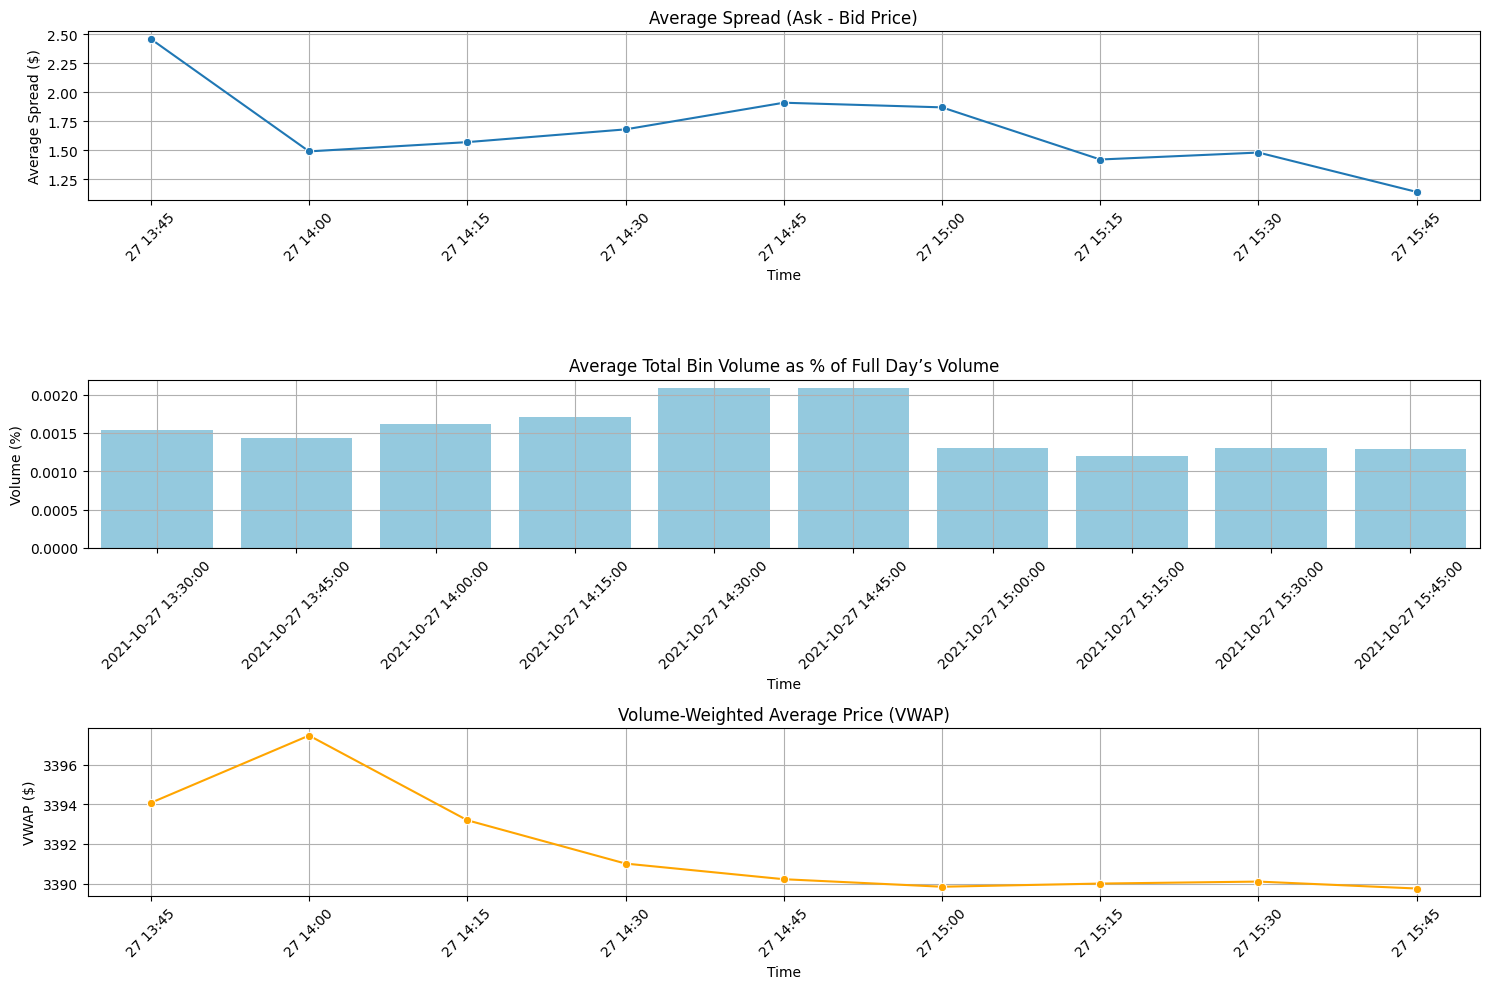

(10, 23)
Visualizing data for BLDE.csv...


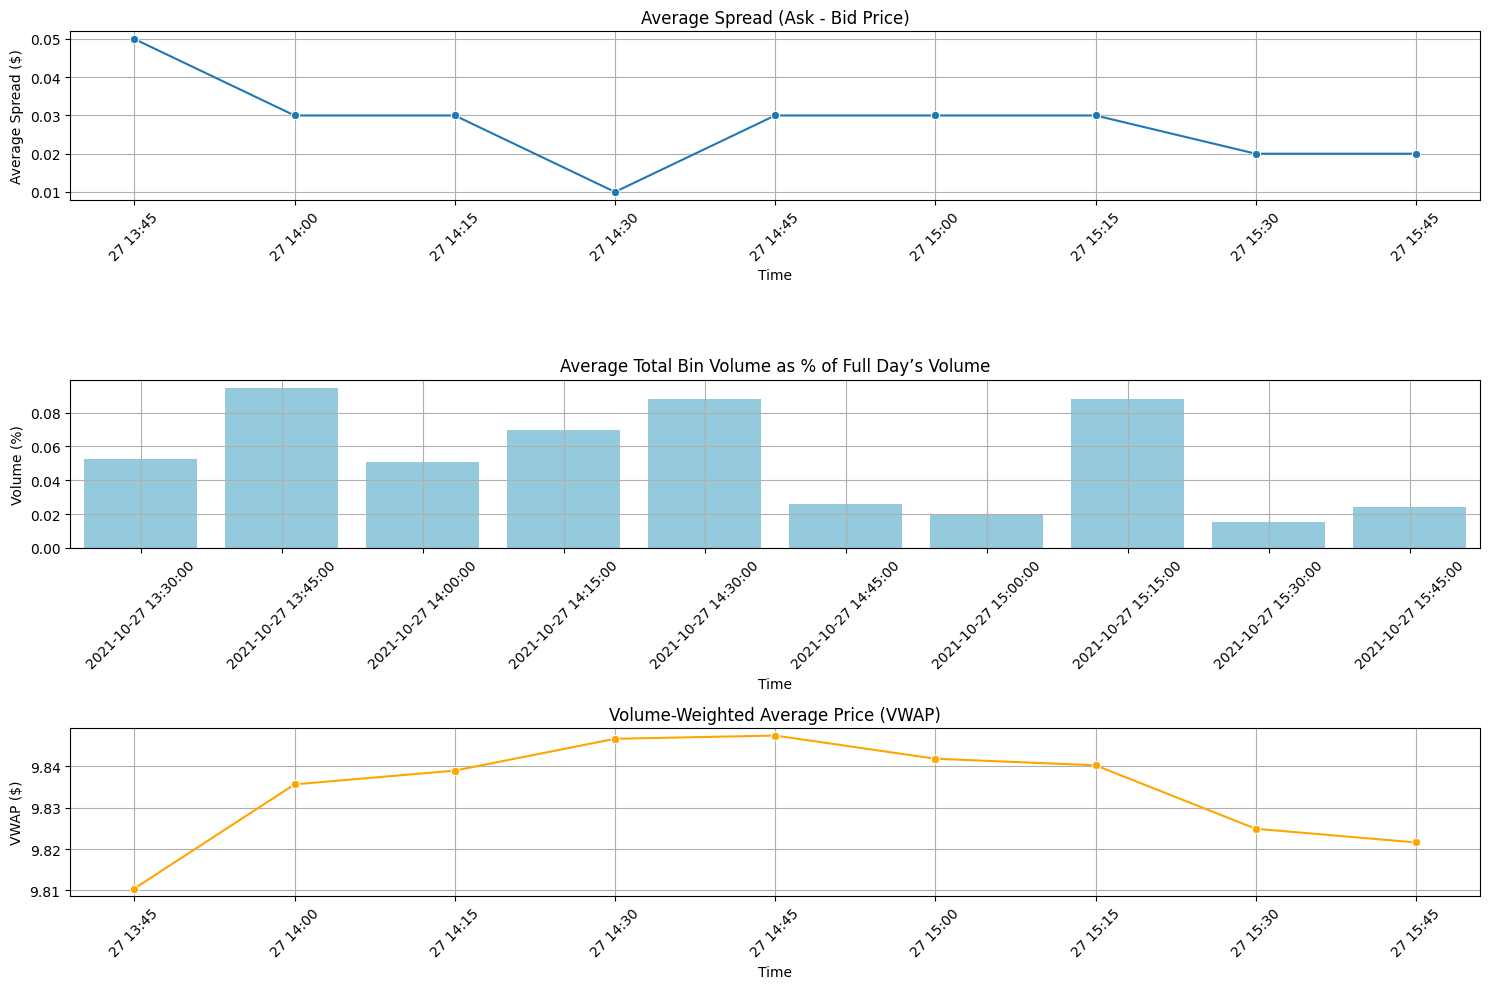

(10, 23)
Visualizing data for CAL.csv...


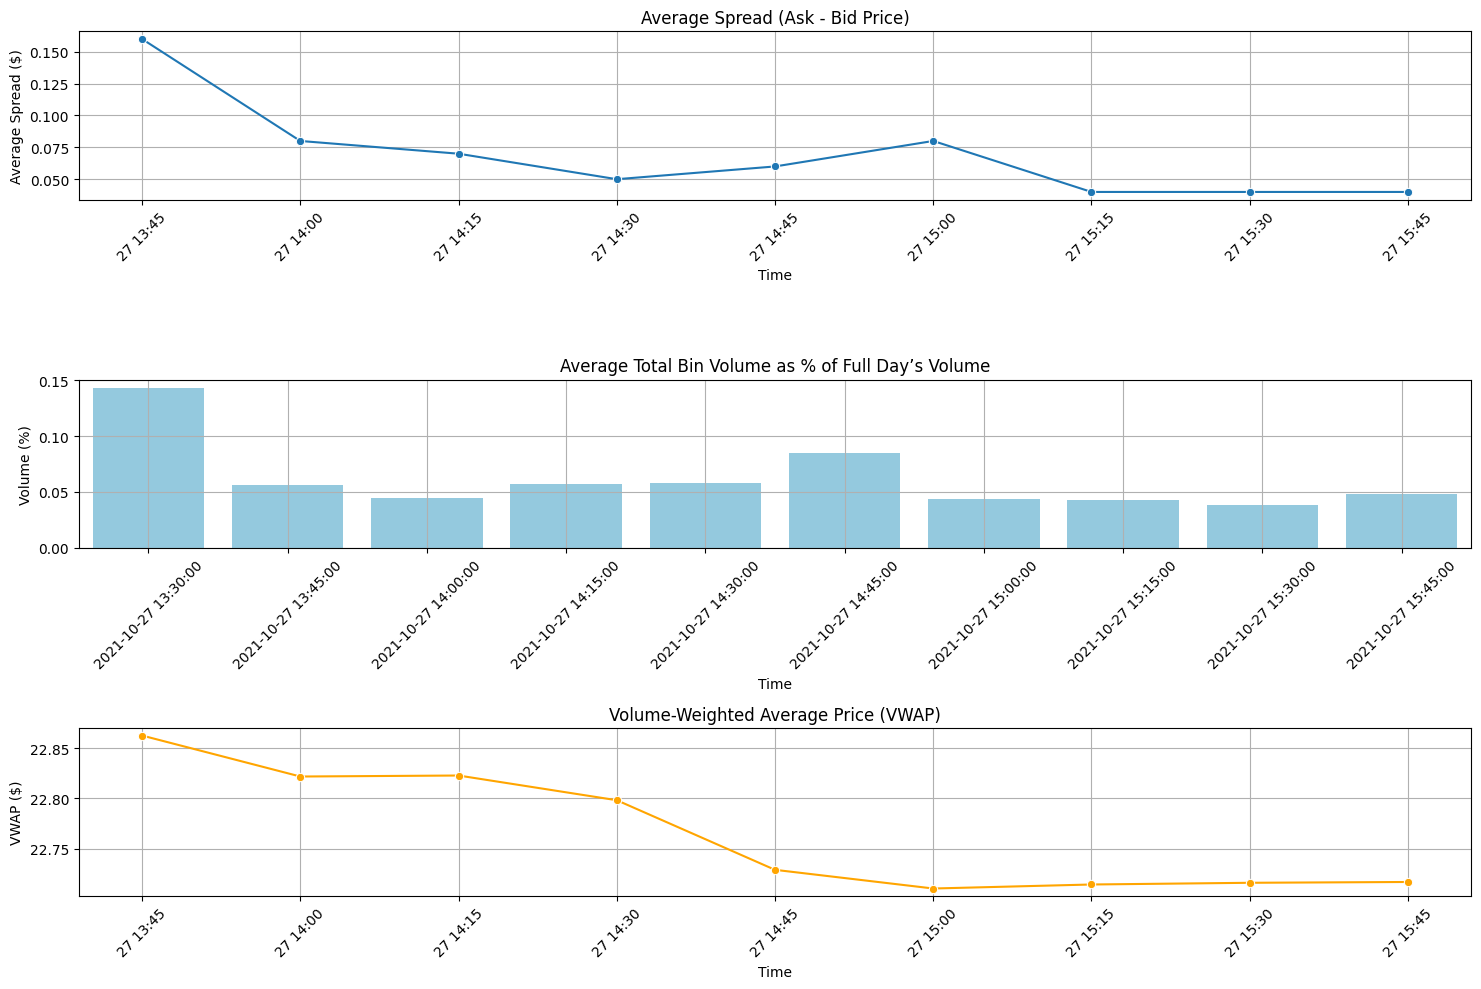

(10, 23)
Visualizing data for KXIN.csv...


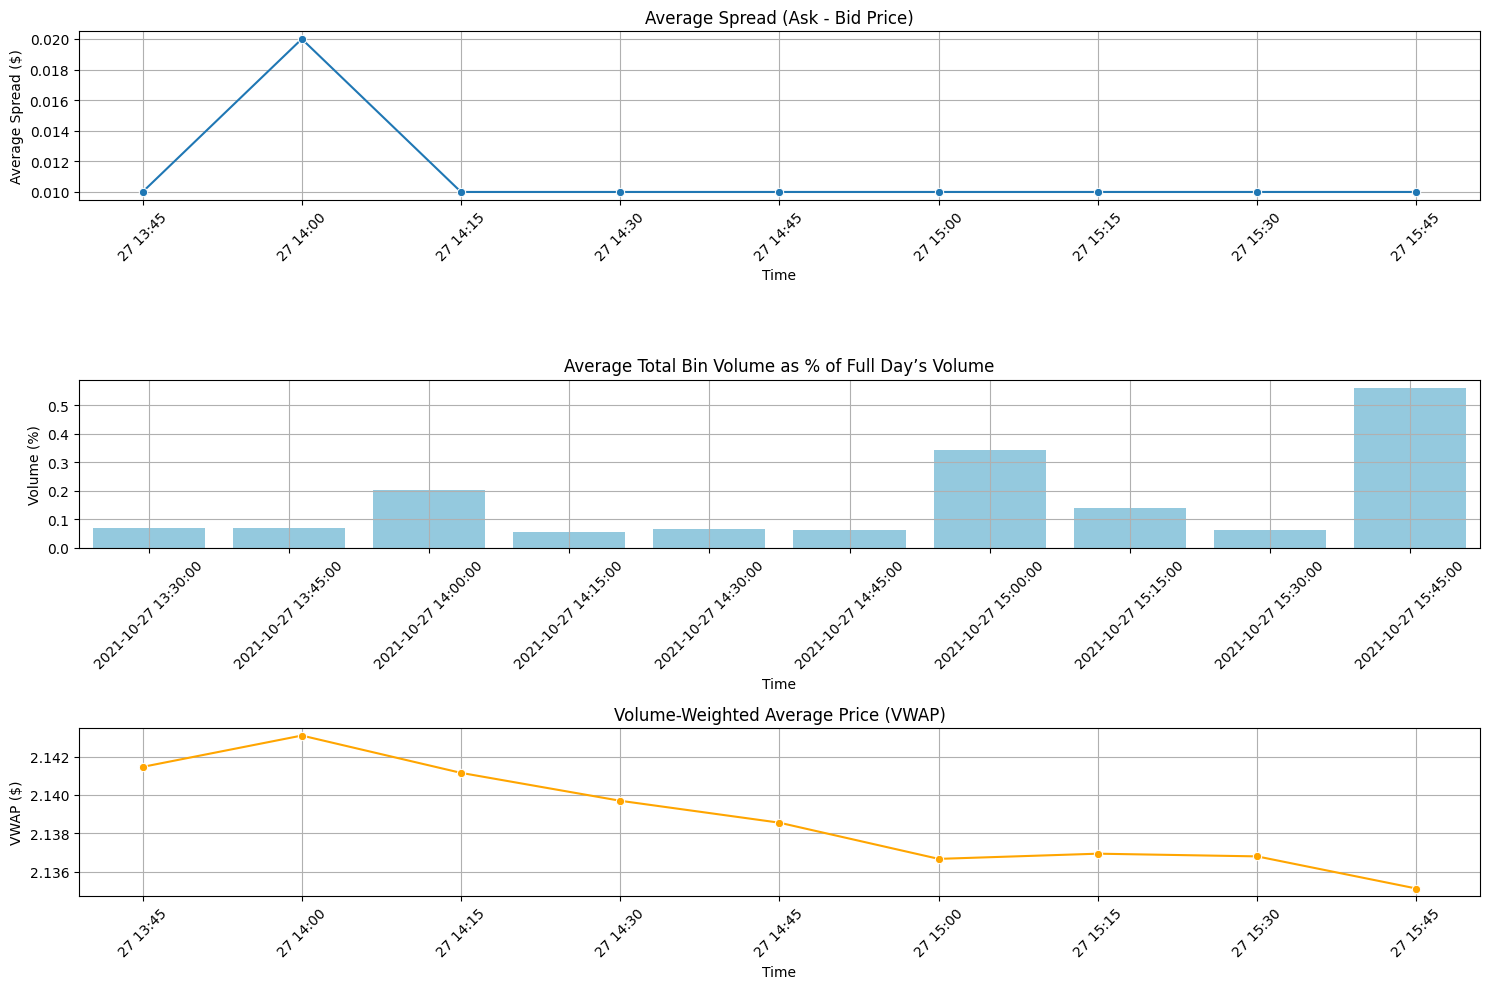

(10, 23)
Visualizing data for PRTS.csv...


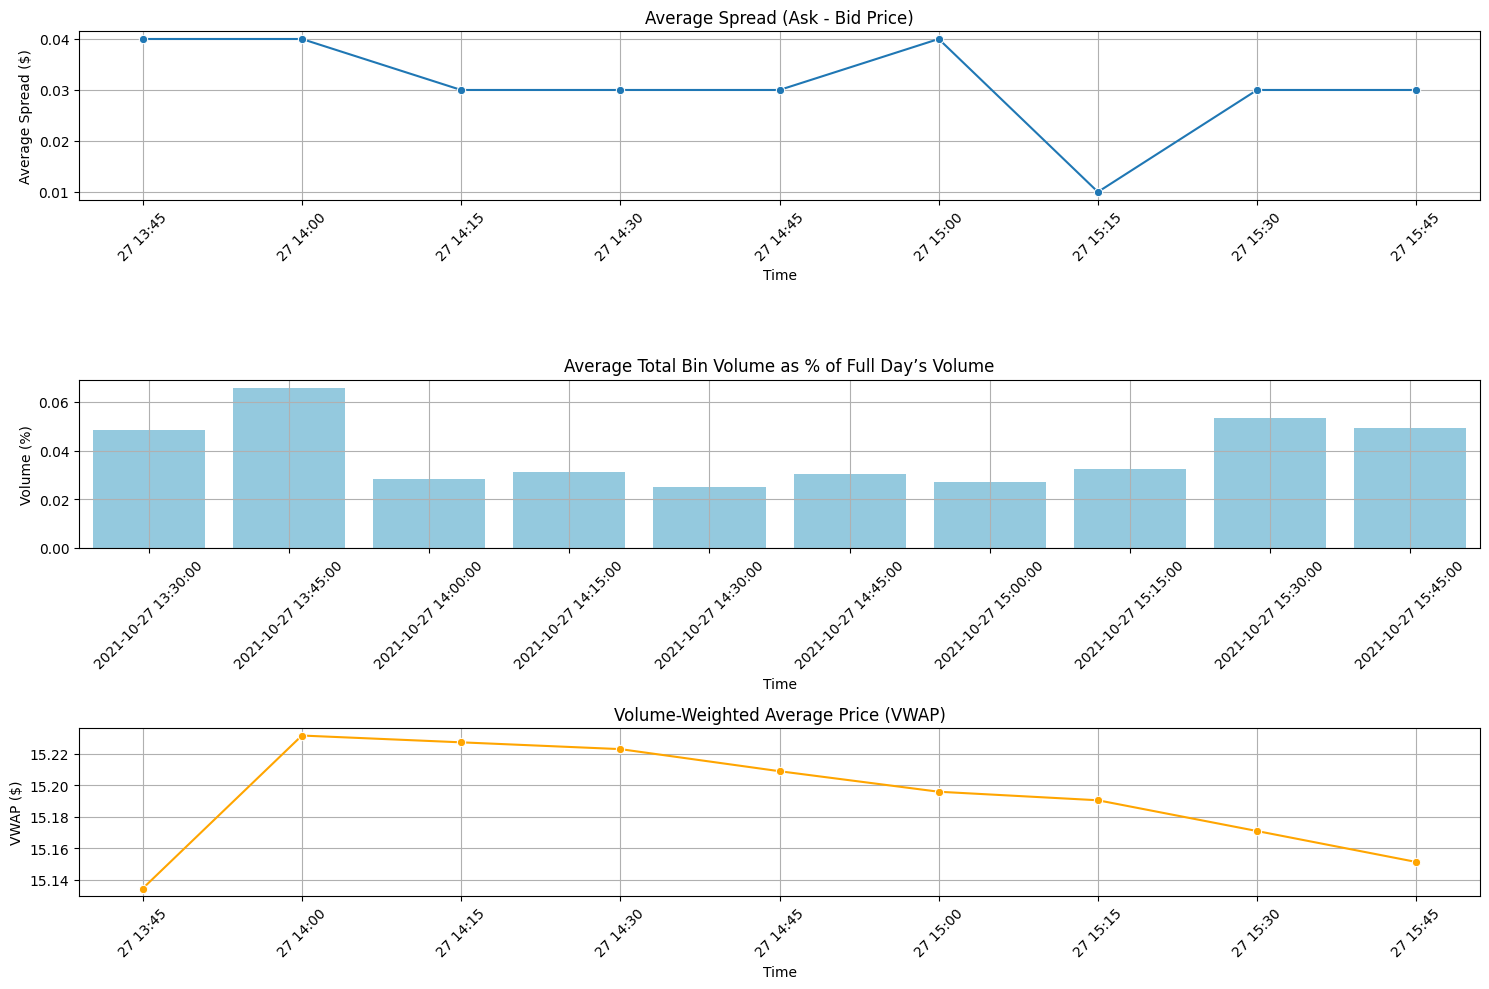

(10, 23)
Visualizing data for SHOO.csv...


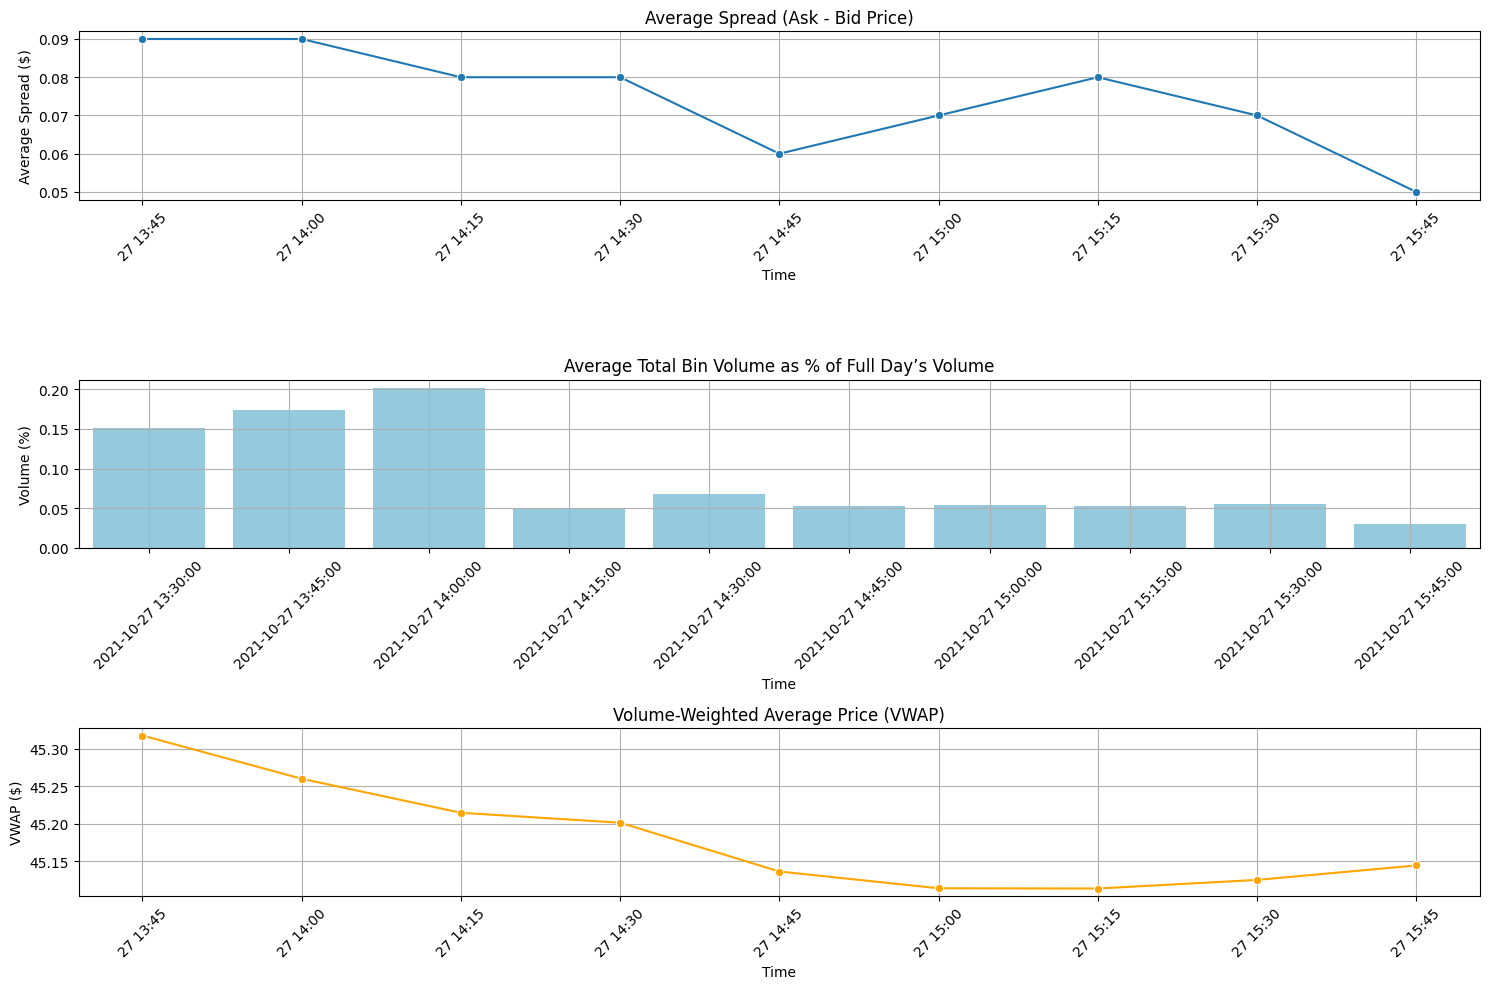

(10, 23)
Visualizing data for SMTC.csv...


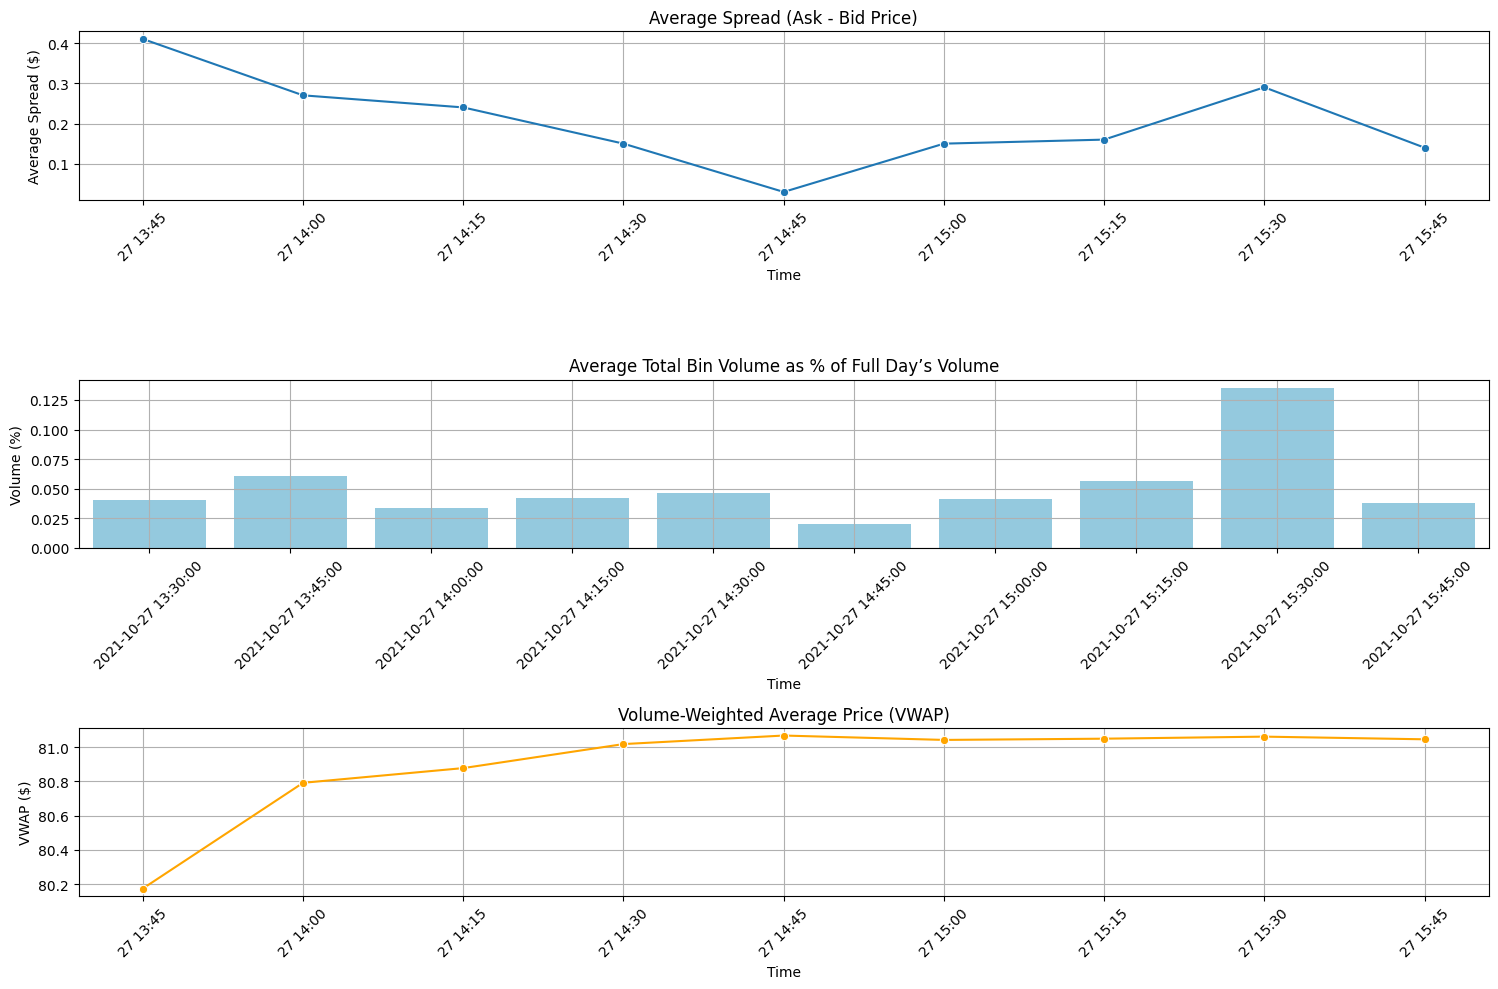

(10, 23)
Visualizing data for TECH.csv...


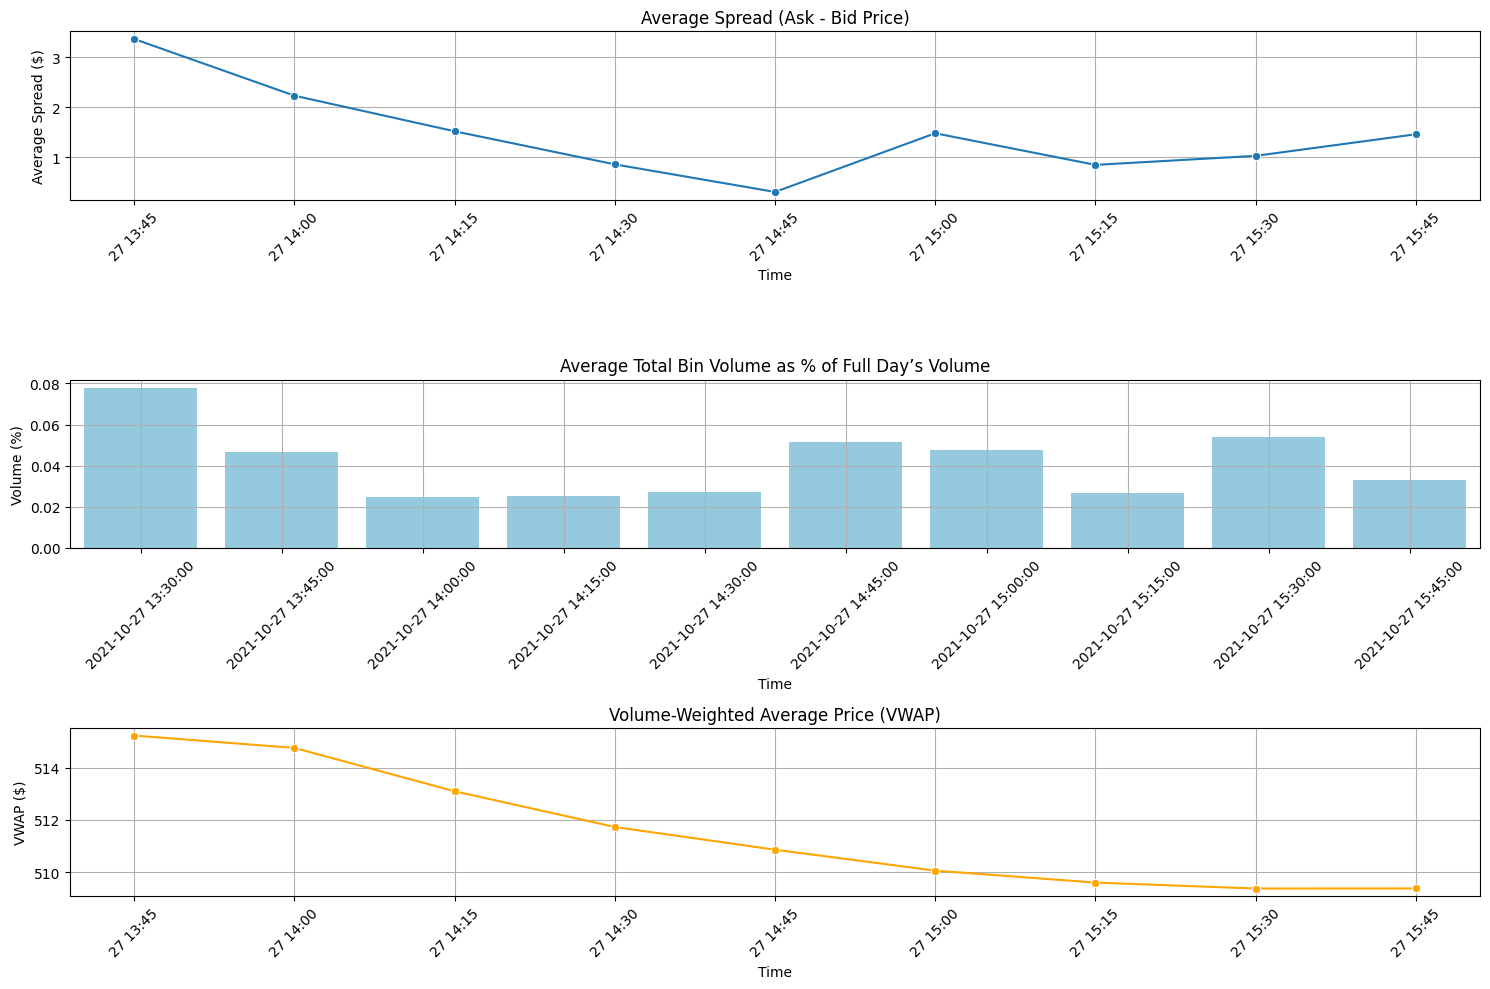

(10, 23)
Visualizing data for TTGT.csv...


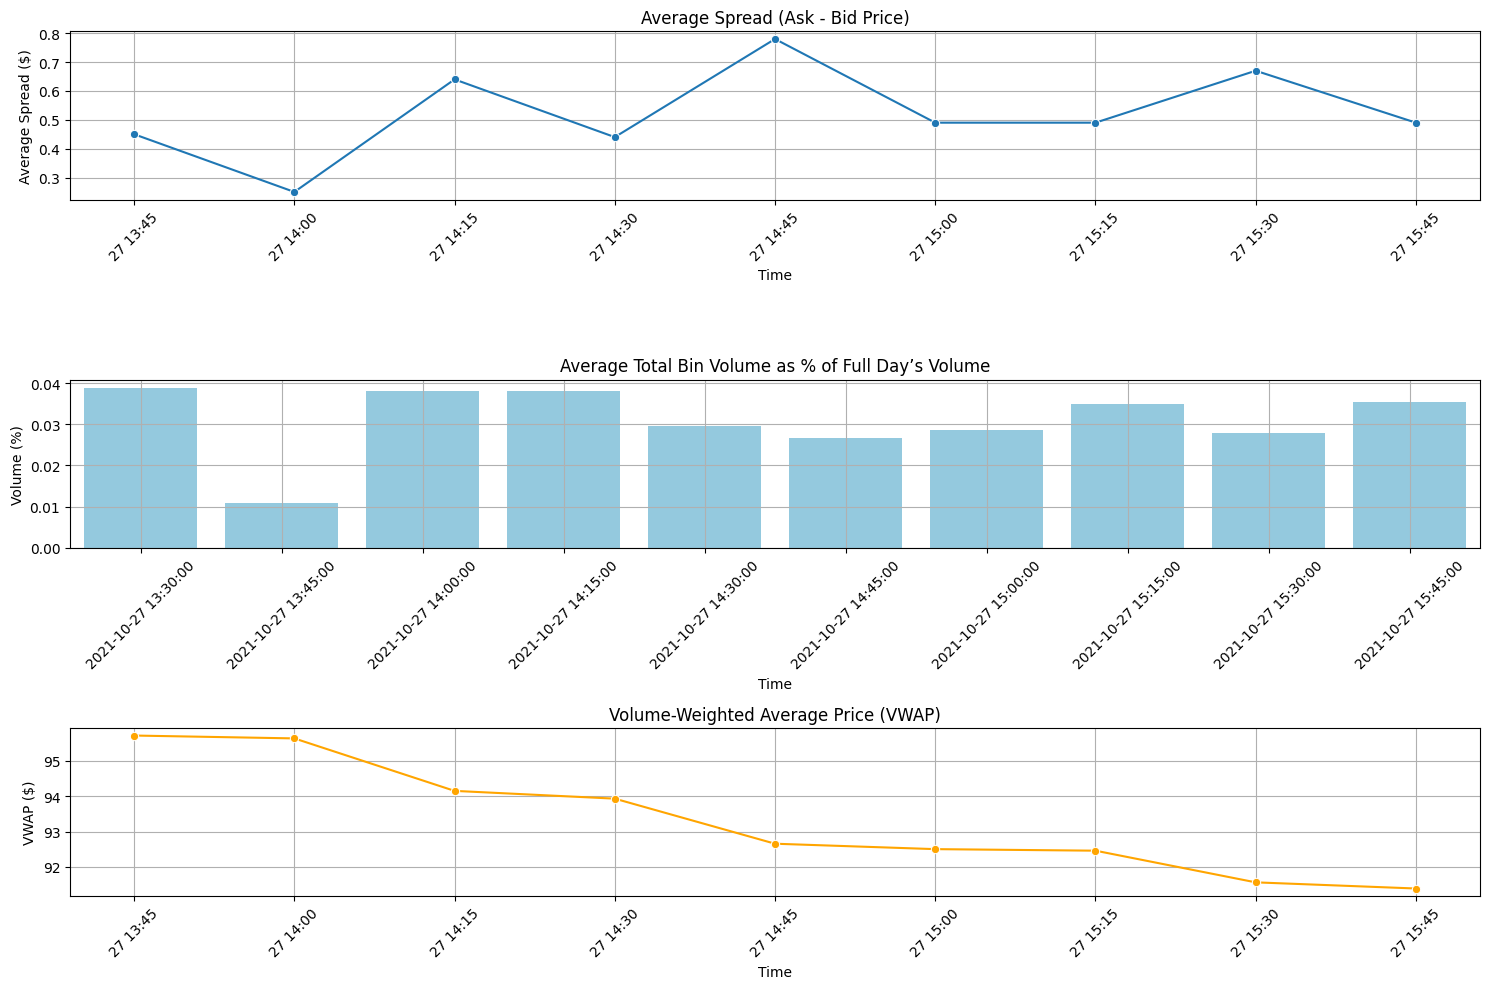

(10, 23)
Visualizing data for XOS.csv...


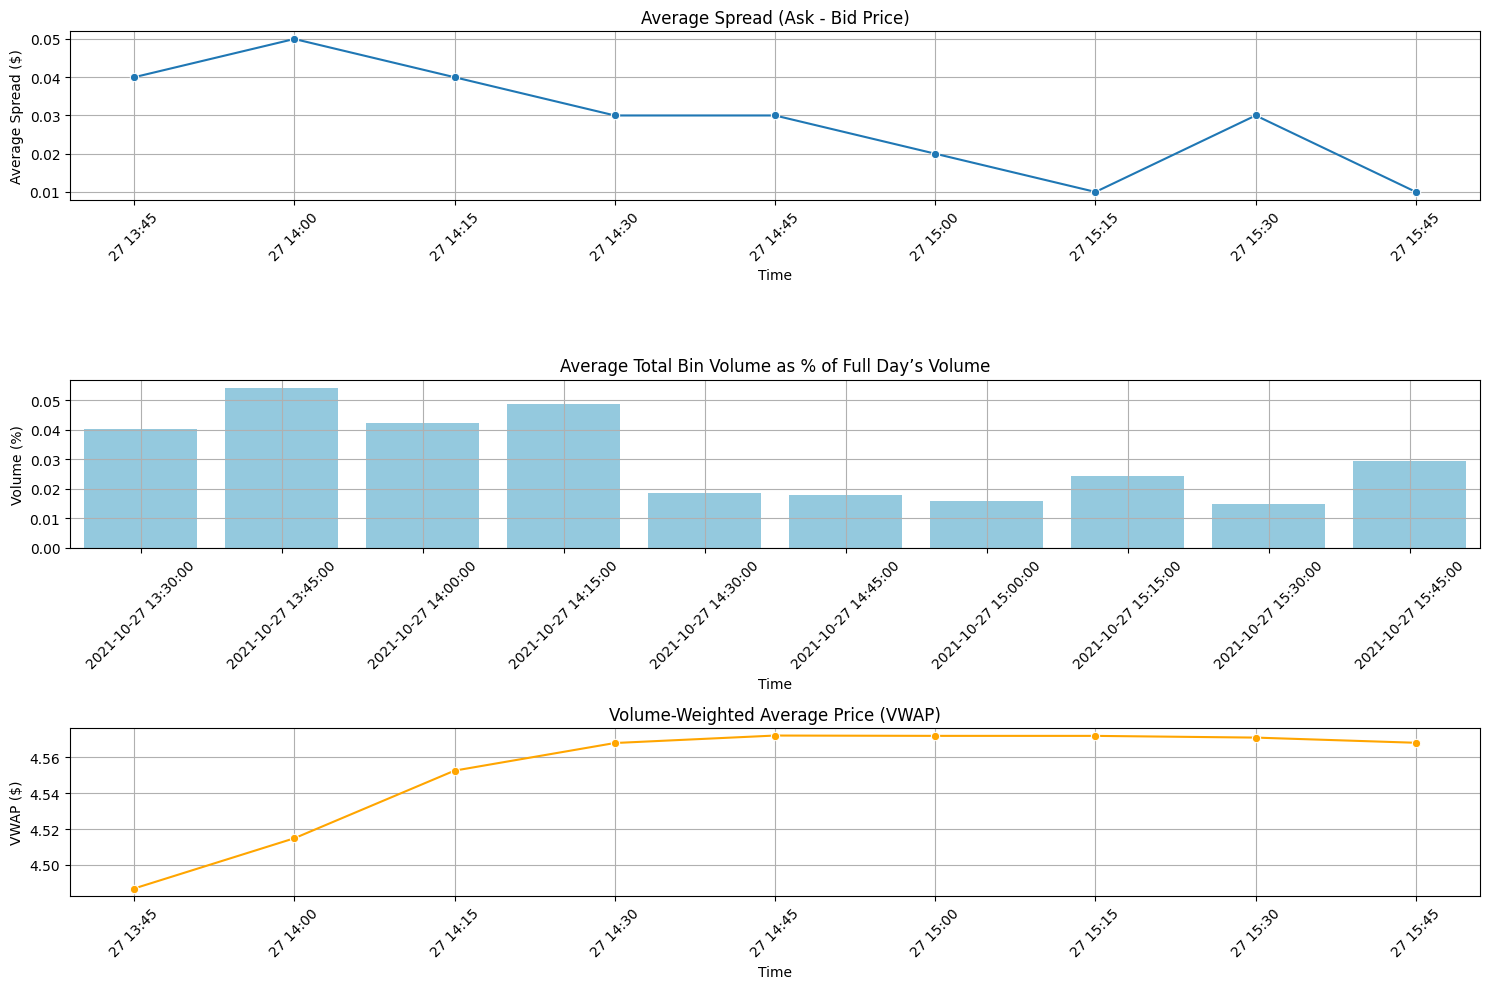

All visualizations are complete.


In [17]:
task_1()

### Task 2

In [19]:
def load_and_process_data(file_path: str) -> pd.DataFrame:
    """
    Load the CSV file, filter for standard trading hours, and remove rows with invalid bid-ask spreads.

    Parameters:
        file_path (str): The path to the CSV file containing the stock trading data.

    Returns:
        pd.DataFrame: The processed DataFrame after filtering and cleaning.
    """
    # Load the data
    df = pd.read_csv(file_path)

    # Remove any leading or trailing spaces from the column names
    df.columns = df.columns.str.strip()

    # Convert the 'timestamp' to datetime format (assuming timestamp is in milliseconds)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

    # Filter for standard trading hours (9:30 AM to 4:00 PM)
    start_time = df['timestamp'].dt.normalize() + timedelta(hours=9, minutes=30)
    end_time = df['timestamp'].dt.normalize() + timedelta(hours=16)
    df = df[(df['timestamp'] >= start_time) & (df['timestamp'] <= end_time)]

    # Calculate the bid-ask spread and remove rows with zero or negative spread
    df['spread'] = df['ask_price'] - df['bid_price']
    df = df[df['spread'] > 0]

    # Drop the temporary 'spread' column as it is not needed in the final DataFrame
    df = df.drop(columns=['spread'])

    return df

In [20]:

def calculate_normalized_mid_price_return(old_df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate the normalized mid-price return from the time of trade to 10 seconds after the trade.
    Formula: ( (Mid (t+10) - Mid (t)) / Mid(t) ) / (Ask (t) - Bid(t))

    Handles duplicate timestamps by keeping the first occurrence.

    Parameters:
        old_df (pd.DataFrame): The processed DataFrame containing the trading data.

    Returns:
        pd.DataFrame: The DataFrame with an additional column 'normalized_mid_price_return' representing the response variable.
    """
    # Step 1: Remove duplicate timestamps by keeping the first occurrence
    df = old_df.drop_duplicates(subset='timestamp', keep='first').copy()

    # Step 2: Convert relevant columns to numeric, handling errors
    df['bid_price'] = pd.to_numeric(df['bid_price'], errors='coerce')
    df['ask_price'] = pd.to_numeric(df['ask_price'], errors='coerce')

    # Step 3: Calculate mid_price at time 't'
    df['mid_price'] = (df['bid_price'] + df['ask_price']) / 2

    # Step 4: Create a new column time_plus_10
    df['time_plus_10'] = df['timestamp'] + pd.Timedelta(seconds=10)

    # Step 5: Initialize mid_price_t_plus_10 column
    df['mid_price_t_plus_10'] = None

    # Step 6: Iterate over each entry to find the closest mid price at time_plus_10
    for idx, row in df.iterrows():
        time_plus_10 = row['time_plus_10']
        
        # Find the closest timestamp that is greater than or equal to time_plus_10
        closest_index = df.index[(df['timestamp'] - time_plus_10).abs().argsort()[:1]].tolist()
        
        if closest_index:
            closest_idx = closest_index[0]
            df.at[idx, 'mid_price_t_plus_10'] = df.at[closest_idx, 'mid_price']

    # Step 7: Calculate the normalized mid-price return using the formula
    df['normalized_mid_price_return'] = (
        (df['mid_price_t_plus_10'] - df['mid_price']) / df['mid_price']
    ) / (df['ask_price'] - df['bid_price'])

    # Step 8: Clean up unnecessary columns
    df.drop(columns=['time_plus_10'], inplace=True)

    return df.reset_index(drop=True)





In [37]:
def calculate_features(new_df: pd.DataFrame, original_df: pd.DataFrame) -> pd.DataFrame:
    """
    Create a training dataset with the required features:
    1. Bid Offer Imbalance
    2. Trade Sign
    3. Trade Size Imbalance over the last 10 seconds
    4. Normalized mid price return

    Parameters:
        new_df (pd.DataFrame): DataFrame with the normalized mid-price return and other calculated values.
        original_df (pd.DataFrame): Original DataFrame with all trade data.

    Returns:
        pd.DataFrame: A new DataFrame with the training features.
    """
    # 1. Calculate Bid Offer Imbalance
    new_df['bid_offer_imbalance'] = (
        (new_df['nbb_agg_size'] - new_df['nbo_agg_size']) /
        (new_df['nbb_agg_size'] + new_df['nbo_agg_size'])
    )

    # 2. Calculate Trade Sign
    original_df['mid_price'] = (original_df['bid_price'] + original_df['ask_price']) / 2
    original_df['trade_sign'] = original_df.apply(lambda row: 1 if row['trade_price'] > row['mid_price'] else -1, axis=1)
    new_df['trade_sign'] = new_df.apply(lambda row: 1 if row['trade_price'] > row['mid_price'] else -1, axis=1)

    # 3. Calculate Trade Size Imbalance over the last 10 seconds for each time interval
    trade_size_imbalances = []
    for i in range(len(new_df) - 1):
        start_time = new_df['timestamp'].iloc[i]
        end_time = new_df['timestamp'].iloc[i + 1]

        # Filter the original data to get the trades within the 10-second interval
        bin_data = original_df[(original_df['timestamp'] >= start_time) & (original_df['timestamp'] < end_time)]

        # Calculate the trade size imbalance for the current 10-second bin
        trade_size_imbalance = (bin_data['trade_sign'] * bin_data['trade_size']).sum() if not bin_data.empty else 0
        trade_size_imbalances.append(trade_size_imbalance)

    # For the last interval, extend the time to include data points until the end of the day (4:00 PM)
    last_start_time = new_df['timestamp'].iloc[-1]
    last_bin_data = original_df[original_df['timestamp'] >= last_start_time]
    last_trade_size_imbalance = (last_bin_data['trade_sign'] * last_bin_data['trade_size']).sum() if not last_bin_data.empty else 0
    trade_size_imbalances.append(last_trade_size_imbalance)

    # Add the trade size imbalance to the new_df
    new_df['trade_size_imbalance'] = trade_size_imbalances

    # Drop unnecessary intermediate columns
    new_df = new_df.drop(columns=['mid_price'])

    # Return the final DataFrame with calculated features
    new_df = new_df[['timestamp', 'bid_offer_imbalance', 'trade_sign', 'trade_size_imbalance', 'normalized_mid_price_return']]
    features = ['bid_offer_imbalance', 'trade_size_imbalance', 'normalized_mid_price_return']
    scaler = StandardScaler()
    new_df[features] = scaler.fit_transform(new_df[features])
    return new_df

In [71]:
def train_and_evaluate_sectional_model(data: pd.DataFrame) -> None:
    """
    Function to perform train-test split, train a sectional linear regression model, and evaluate its accuracy.

    Parameters:
        data (pd.DataFrame): The DataFrame containing features and response variables:
                             ['timestamp', 'bid_offer_imbalance', 'trade_sign', 'trade_size_imbalance', 'normalized_mid_price_return'].

    Returns:
        None
    """
    # Step 1: Prepare the features (X) and target (y)
    X = data[['bid_offer_imbalance', 'trade_sign', 'trade_size_imbalance']]
    y = data['normalized_mid_price_return']

    # Step 2: Split the dataset into training and testing sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Step 3: Define breakpoints for sectional regression
    # You can change these breakpoints as per your data distribution
    breakpoints = [-np.inf, -1, 0, np.inf]  # Example breakpoints based on trade_size_imbalance
    segment_models = []

    # Step 4: Fit a separate linear regression model for each segment
    for i in range(len(breakpoints) - 1):
        mask = (X_train['trade_size_imbalance'] > breakpoints[i]) & (X_train['trade_size_imbalance'] <= breakpoints[i + 1])
        if np.any(mask):  # Ensure there are samples in the segment 
            model = LinearRegression()
            model.fit(X_train[mask], y_train[mask])
            segment_models.append([i, model])
        else:
            print(f"No samples found in segment {breakpoints[i]} to {breakpoints[i + 1]}. Skipping...")

    # Step 5: Make predictions on the test data using the appropriate model
    y_pred = np.zeros(X_test.shape[0])
    for i in segment_models:
        mask = (X_test['trade_size_imbalance'] > breakpoints[i[0]]) & (X_test['trade_size_imbalance'] <= breakpoints[i[0] + 1])
        if np.any(mask):  # Ensure there are samples in the segment
            y_pred[mask] = i[1].predict(X_test[mask])

    # Step 6: Calculate Mean Absolute Error (MAE) for regression accuracy
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Mean Absolute Error (MAE): {mae:.4f}")

    # Optional: Display coefficients of the model for interpretability
    for i, model in enumerate(segment_models):
        print(f"Model Coefficients for segment {model[0] + 1}: {model[1].coef_}")
        print(f"Intercept for segment {model[0] + 1}: {model[1].intercept_}")
        

In [38]:
df = load_and_process_data('DATA/BLDE.csv')
new_df = calculate_normalized_mid_price_return(df)
training_dataset = calculate_features(new_df, df)


In [42]:
training_dataset.head(20)

,timestamp,bid_offer_imbalance,trade_sign,trade_size_imbalance,normalized_mid_price_return
0,2021-10-27 13:30:00.380,2.111103,-1,0.106397,-0.224124
1,2021-10-27 13:30:00.481,0.379078,-1,-1.225442,-0.189639
2,2021-10-27 13:30:00.527,0.379078,-1,-0.029236,-0.189639
3,2021-10-27 13:30:00.554,0.379078,-1,-0.063144,-0.189639
4,2021-10-27 13:30:00.555,0.379078,-1,-0.063144,-0.189639
5,2021-10-27 13:30:04.082,0.782813,1,0.127118,-0.012837
6,2021-10-27 13:30:04.175,0.782813,1,0.127118,-0.012837
7,2021-10-27 13:30:05.734,0.782813,1,0.129002,-0.012837
8,2021-10-27 13:30:33.630,2.258063,-1,0.096978,-0.012837
9,2021-10-27 13:31:45.598,1.927404,-1,0.123351,-0.012837


In [46]:
train_and_evaluate_sectional_model(training_dataset)

Mean Absolute Error (MAE): 0.5008
Model Coefficients for segment 1: [-0.29785629  0.         -0.02806646]
Intercept for segment 1: -0.16731058997484088
Model Coefficients for segment 2: [0.38047361 0.85534266 0.8185345 ]
Intercept for segment 2: 0.6014731874666865
Model Coefficients for segment 3: [0.08853139 0.04038077 1.11412831]
Intercept for segment 3: -0.11521420751362178


In [47]:
def task_2(directory_path: str = 'DATA/') -> None:
    """
    This function iterates over all CSV files in the specified directory, performs data loading,
    filtering, resampling, and visualizes the data for each file.

    Parameters:
        directory_path (str): The path to the directory containing the CSV files. Default is 'DATA/'.
    """
    # List all files in the directory that end with '.csv'
    csv_files = [f for f in os.listdir(directory_path) if f.endswith('.csv')]

    # Loop through each CSV file in the directory
    for csv_file in csv_files:
        file_path = os.path.join(directory_path, csv_file)
        
        # Load and filter the data
        df = load_and_process_data(file_path)
        
        new_df = calculate_normalized_mid_price_return(df)

        training_dataset = calculate_features(new_df, df)

        print(f'Predicting data for {csv_file}...')
        train_and_evaluate_sectional_model(training_dataset)

    print('All predictions are complete.')

In [48]:
task_2()

Predicting data for AMZN.csv...
Mean Absolute Error (MAE): 0.4365
Model Coefficients for segment 1: [-0.0544821   0.50392352 -0.00900884]
Intercept for segment 1: 0.1750799218984993
Model Coefficients for segment 2: [0.06410951 0.14900488 0.06901563]
Intercept for segment 2: 0.0737743611151601
Model Coefficients for segment 3: [0.05212865 0.04295123 0.029443  ]
Intercept for segment 3: 0.017439733746428383
Predicting data for BLDE.csv...
Mean Absolute Error (MAE): 0.5008
Model Coefficients for segment 1: [-0.29785629  0.         -0.02806646]
Intercept for segment 1: -0.16731058997484088
Model Coefficients for segment 2: [0.38047361 0.85534266 0.8185345 ]
Intercept for segment 2: 0.6014731874666865
Model Coefficients for segment 3: [0.08853139 0.04038077 1.11412831]
Intercept for segment 3: -0.11521420751362178
Predicting data for CAL.csv...
Mean Absolute Error (MAE): 0.5261
Model Coefficients for segment 1: [0.09943711 0.         0.07081507]
Intercept for segment 1: -0.5795390343711442

### Task 3

In [60]:
def task_3(directory_path: str = 'DATA/') -> None:
    """
    This function iterates over all CSV files in the specified directory, performs data loading,
    filtering, resampling, and visualizes the data for each file.

    Parameters:
        directory_path (str): The path to the directory containing the CSV files. Default is 'DATA/'.
    """
    # List all files in the directory that end with '.csv'
    csv_files = [f for f in os.listdir(directory_path) if f.endswith('.csv')]

    # Loop through each CSV file in the directory
    for csv_file in csv_files:
        file_path = os.path.join(directory_path, csv_file)
        
        # Load and filter the data
        df = load_and_process_data(file_path)
        
        new_df = calculate_normalized_mid_price_return(df)

        training_dataset = calculate_features(new_df, df)
        training_dataset = sample_data(training_dataset, 15)
        print(f'Predicting data for {csv_file}...')
        train_and_evaluate_sectional_model(training_dataset)

    print('All predictions are complete.')

In [68]:
df = load_and_process_data("./DATA/PRTS.csv")
        
new_df = calculate_normalized_mid_price_return(df)

training_dataset = calculate_features(new_df, df)
training_dataset = sample_data(training_dataset, 15)

(10, 5)


In [69]:
training_dataset.head(20)

,timestamp,bid_offer_imbalance,trade_sign,trade_size_imbalance,normalized_mid_price_return
0,2021-10-27 13:30:00,NaN,NaN,NaN,NaN
1,2021-10-27 13:45:00,-1.437682,-1.0,-0.303898,0.950066
2,2021-10-27 14:00:00,0.711090,1.0,0.253103,0.083308
3,2021-10-27 14:15:00,-0.823747,-1.0,0.082024,0.083308
4,2021-10-27 14:30:00,-1.700797,-1.0,0.086003,0.083308
5,2021-10-27 14:45:00,-0.904528,1.0,0.491818,0.083308
6,2021-10-27 15:00:00,-0.056328,1.0,0.101917,0.083308
7,2021-10-27 15:15:00,-0.056328,1.0,0.205360,0.083308
8,2021-10-27 15:30:00,-1.591166,-1.0,-0.367555,0.083308
9,2021-10-27 15:45:00,-0.823747,1.0,0.105896,0.083308


In [72]:
train_and_evaluate_sectional_model(training_dataset)

No samples found in segment -inf to -1. Skipping...
No samples found in segment -1 to 0. Skipping...
Mean Absolute Error (MAE): 0.5167
Model Coefficients for segment 3: [0. 0. 0.]
Intercept for segment 3: 0.08330804277472546


In [73]:
task_3()

(10, 5)
Predicting data for AMZN.csv...
No samples found in segment -inf to -1. Skipping...
Mean Absolute Error (MAE): 0.1734
Model Coefficients for segment 2: [0.49700235 0.         0.03612434]
Intercept for segment 2: -0.6205431227871578
Model Coefficients for segment 3: [0.20514632 0.26637876 0.0019112 ]
Intercept for segment 3: -0.44598432220414863
(10, 5)
Predicting data for BLDE.csv...
No samples found in segment -inf to -1. Skipping...
No samples found in segment -1 to 0. Skipping...
Mean Absolute Error (MAE): 0.2082
Model Coefficients for segment 3: [ 0.07767797 -0.03797927 -0.14816688]
Intercept for segment 3: 0.009722800895748639
(10, 5)
Predicting data for CAL.csv...
No samples found in segment -inf to -1. Skipping...
No samples found in segment -1 to 0. Skipping...
Mean Absolute Error (MAE): 0.3398
Model Coefficients for segment 3: [ 0.14180606  0.11642914 -0.13241002]
Intercept for segment 3: -0.23119383395622578
(10, 5)
Predicting data for KXIN.csv...
No samples found in 

### Task 4

In [52]:
def calculate_annualized_volatility(processed_df):
    processed_df['mid_price'] = (processed_df['bid_price'] + processed_df['ask_price']) / 2
    
    # Step 2: Set the timestamp as the index
    processed_df.set_index('timestamp', inplace=True)
    
    # Step 3: Handle duplicate timestamps by aggregating mid prices
    # Here we take the average mid price for duplicate timestamps
    processed_df = processed_df.groupby(processed_df.index).agg({'mid_price': 'mean'}).reset_index()

    # Step 4: Resample data to 15-second frequency, taking the last mid price in each interval
    mid_price_resampled = processed_df.set_index('timestamp').resample('15S').last()

    # Step 5: Calculate returns
    mid_price_returns = mid_price_resampled['mid_price'].pct_change().dropna()

    # Step 6: Resample returns to 30-minute intervals and calculate annualized volatility
    returns_30min = mid_price_returns.resample('30T').apply(lambda x: np.std(x) * np.sqrt(252 * 60 * 60 * 24))  # annualize the volatility

    return returns_30min

In [53]:
df = load_and_filter_data('DATA/SHOO.csv')
returns_30min = calculate_annualized_volatility(df)

In [55]:
returns_30min.head()

timestamp
2021-10-27 13:30:00    5.456547
2021-10-27 14:00:00    2.442250
2021-10-27 14:30:00    1.665249
2021-10-27 15:00:00    1.761186
2021-10-27 15:30:00    1.667260
Freq: 30T, Name: mid_price, dtype: float64

In [56]:
def plot_annualized_volatility(returns_30min):
    # Create a figure and axis for the plot
    plt.figure(figsize=(12, 6))
    
    # Plot the annualized volatility
    plt.plot(returns_30min.index, returns_30min.values, marker='o', linestyle='-', color='b', label='Annualized Volatility')

    # Adding title and labels
    plt.title('Annualized Volatility (15-second Mid Price Returns) Over Time')
    plt.xlabel('Time')
    plt.ylabel('Annualized Volatility')
    
    # Optional: Adding grid
    plt.grid()

    # Optional: Adding a legend
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()


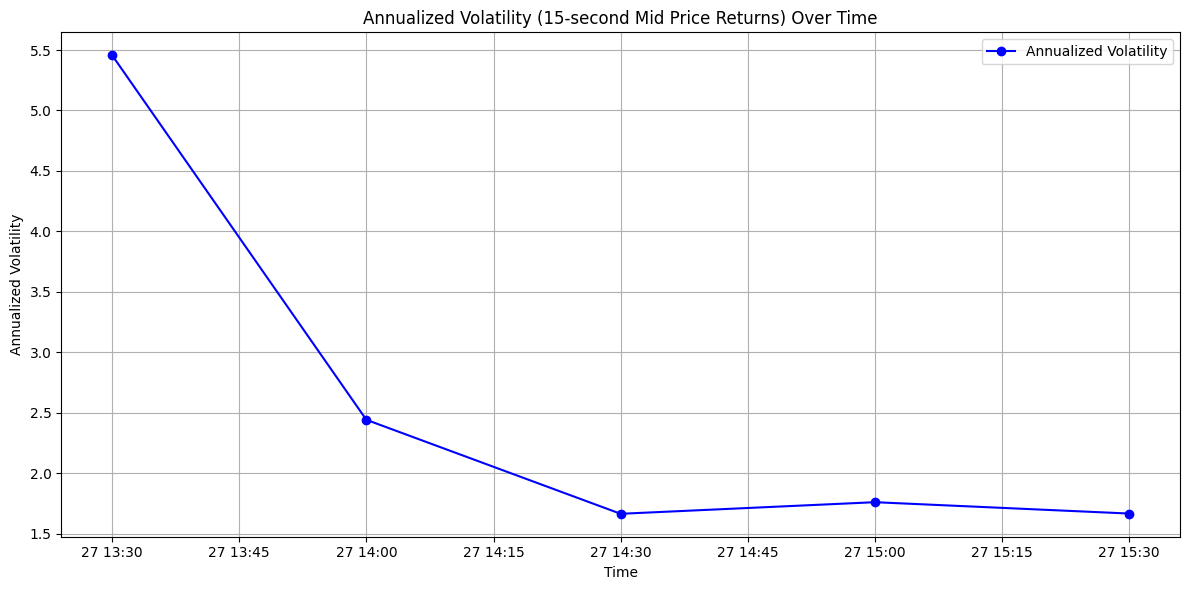

In [57]:
plot_annualized_volatility(returns_30min)